In [1]:
%load_ext rqalpha
%matplotlib inline

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


In [4]:
import talib
import numpy as np
import pandas as pd
from pyecharts import Grid, Bar, Line, Kline, Overlap

# 读取CSV数据
data=pd.read_csv("/home/quant/RQAlpha/trunk/data/daily/cn/xshg/600519.csv.txt",header=1)
data.columns=['date','code','name','close','high','low','open','last_close','change','change_rate','turnover_rate','volume','amount','totoal_market_cap','fa_market_cap','turnover'
]

#这里需要反转一下DF
data = data.reindex(data.index[::-1])

ochl = data[['open', 'close', 'high', 'low','volume']]
ochl_tolist = [ochl.iloc[i].tolist() for i in range(len(ochl))]

sma_5 = talib.EMA(np.array(data['close']), 5)
sma_20 = talib.EMA(np.array(data['close']), 20)
sma_60 = talib.EMA(np.array(data['close']), 60)


kline = Kline()
kline.add("daily", data['date'], ochl_tolist, is_datazoom_show=True)

line = Line()
line.add('5d MA', data['date'], sma_5, is_fill=False, line_opacity=0.8, is_smooth=True)
line.add('20d MA', data['date'], sma_20, is_fill=False, line_opacity=0.8, is_smooth=True)
line.add('60d MA', data['date'], sma_60, is_fill=False, line_opacity=0.8, is_smooth=True)


#bar = Bar()
#bar.add("Volume", data['date'], data['volume'], is_stack=True)

overlap = Overlap()
overlap.add(kline)
overlap.add(line)
#overlap.add(bar)

overlap

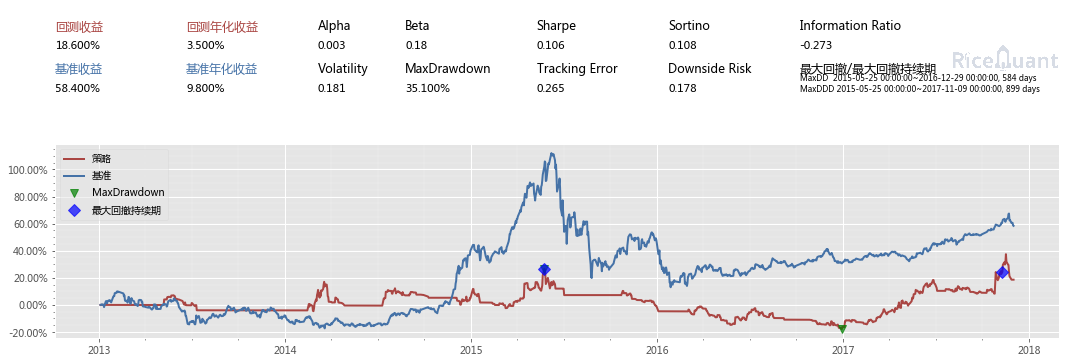

{'sys_analyser': {'benchmark_portfolio':               cash  market_value  static_unit_net_value  total_value  \
  date                                                                   
  2013-01-04  333.64     999666.36                  1.000   1000000.00   
  2013-01-07  333.64    1004248.08                  1.000   1004581.72   
  2013-01-08  333.64    1000030.68                  1.005   1000364.32   
  2013-01-09  333.64    1000347.48                  1.000   1000681.12   
  2013-01-10  333.64    1002105.72                  1.001   1002439.36   
  2013-01-11  333.64     983359.08                  1.002    983692.72   
  2013-01-14  333.64    1020777.12                  0.984   1021110.76   
  2013-01-15  333.64    1027960.56                  1.021   1028294.20   
  2013-01-16  333.64    1020527.64                  1.028   1020861.28   
  2013-01-17  333.64    1010892.96                  1.021   1011226.60   
  2013-01-18  333.64    1027794.24                  1.011   1028127.88   

In [7]:
from rqalpha import run_file

config = {
  "base": {
    "start_date": "2013-01-01",   # backtest start date 
    "end_date": "2017-12-01",   #  backtest end date 
    "benchmark": "000300.XSHG", #  benchmark
    "accounts": {
      "stock": 1000000  # stock account initial cash
    }
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
     "sys_analyser": {
      "enabled": True, #  sys_analyser
      "plot": True  # sys_analyser plotting
    }
  }
}

strategy_file_path = "./moving_average_strategy_for_chinese_a_share.py"

run_file(strategy_file_path, config)

In [ ]:
%rqalpha -s 20160101 -e 20171020 --account stock 100000 -fq 1d -p -bm 000300.XSHG -o ./analysise.pkl --locale en --log-level verbose
import talib

def init(context):
    # initial operation
    print ('init entered')
    context.s1 = '000001.XSHE'    #  000001.XSHE
    context.AvgLen1 = 6    # EMA6
    context.AvgLen2 = 12    # EMA12
    context.AvgLen3 = 28    # EMA28
    context.RLength = 4    # 
    context.High = 0.0
    context.Low = 0.0
    
    print ('init finished')
    
def before_trading(context):
    # do something before daily trading session start
    print ('before_trading entered')
    # noup
    print ('before_trading finished')
    pass


def compute_data(context, bar_dict):
    # compute historical data for analysing and trading
    Data = history_bars(context.s1, context.AvgLen3, 
                        '1d', ['close', 'high', 'low'], 
                        skip_suspended=True, include_now=False)  
    Close = Data['close']
    # price changing range
    Range = Data['high'] - Data['low']   
    
    High = Data['high'][-1]
    Low = Data['low'][-1]
    
    #  compute MAs using TA-lib
    EMA1 = talib.EMA(Close, context.AvgLen1)[-1]
    EMA2 = talib.EMA(Close, context.AvgLen2)[-1]
    EMA3 = talib.EMA(Close, context.AvgLen3)[-1]
    #  compute range using TA-lib
    RangeL = talib.SMA(Range[-context.RLength:], context.RLength)[-1]

    return EMA1, EMA2, EMA3, RangeL, High, Low
     
def handle_bar(context, bar_dict):
    # handle every daily bar data
    print ('handle_bar entered')
        
    # holdings quantity in current portfolio
    cur_position = context.portfolio.positions[context.s1].quantity
    # quantity cash available for buying
    shares = context.portfolio.cash / bar_dict[context.s1].close
    
    print (cur_position)
    print (shares)
    
    # compute technical indicators
    EMA1, EMA2, EMA3, RangeL, High, Low = compute_data(context, bar_dict)
    
    # ma golden cross, All in
    if EMA1 > EMA2 > EMA3: 
            order_shares(context.s1, shares)
            context.Low = Low
            print('Buy signal, All in')
    
    # dead cross or ma start crossing down 
    if (EMA1 < EMA2) or (EMA1 < (context.Low + RangeL)):   
            order_target_value(context.s1, 0)
            print('Sell signal, All out') 
    
    print ('handle_bar finished')
    
def after_trading(context):
    # do something after daily trading session finish
    print ('after_trading entered')
    # noup
    print ('after_trading finished')
    pass